# Cortical network model

Analysis of 3-population cortical network model with a focus on the effect of the synaptic strength on the network dynamics evoked by a stimulus

## Imports

In [1]:
%load_ext autoreload
%load_ext usnm2p.skip_kernel_extension
%autoreload 2

In [2]:
# External imports
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import jupyter_slack

# Internal modules
from usnm2p.logger import logger
from usnm2p.network_model import *
from usnm2p.utils import *
from usnm2p.fileops import get_data_root, load_lineagg_data, save_figs_book
from usnm2p.constants import *
from usnm2p.batchutils import *
from usnm2p.plotters import plot_table, harmonize_axes_limits
from usnm2p.postpro import get_fit_table, get_change_key, get_propagg_keys, compute_predictor, bin_by_quantile_intervals, free_expand
from usnm2p.model_params import *

# Initialize empty figures dictionary
figs = {}

# Set up logging folder
logdir = get_data_root(kind=DataRoot.MODEL)

### Input data parameters

In [3]:
# Parameters determining location of reference activity profiles
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
layer = None  # cortical layer
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
gcamp_key = get_gcamp_key(None)  # GCaMP key
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
errprop = 'inter'

# Processing parameters
slack_notify = False   # notify start and completion on slack
run_state_dep = False  # Whether to run state-dependency analysis

### Dervied parameters

 2025/07/31 17:26:23: circuit model analysis notebook started on 2025-07-31 at 17:26:23
 2025/07/31 17:26:23: assembling batch analysis settings...


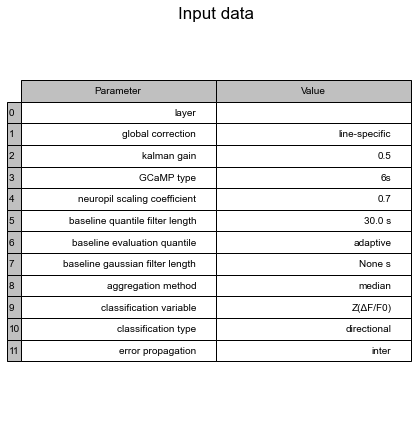

In [4]:
skip_state_dep = not run_state_dep  # Whether to skip state-dependency analysis

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'circuit model analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

# Get data input directory
_, input_dir, figsdir, _ = get_batch_settings(
    analysis_type, None, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

# Plot dataset info table
figs['dataset_info'] = plot_table({
    'layer': layer,
    'global correction': 'line-specific' if isinstance(global_correction, dict) else global_correction,
    'kalman gain': kalman_gain,
    'GCaMP type': gcamp_key,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'error propagation': errprop,
    }, title='Input data', aspect=1.5)

### Load data and compute raw response profiles

 2025/07/31 17:26:24: loading line-average data (with inter-propagated SE)
 2025/07/31 17:26:24: loading line3 data from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_stim-1->stimeverytrial/main folder
 2025/07/31 17:26:24: loading sst data from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_stim-1->stimeverytrial/main folder
 2025/07/31 17:26:24: loading pv data from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_stim-1->stimeverytrial/main folder
 2025/07/31 17:26:24: loading sarah_line3 data from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/sui

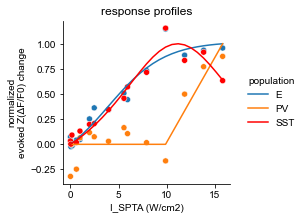

In [5]:
# Load line-aggregated stats
stats, counts = load_lineagg_data(input_dir, errprop=errprop)

# Restrict to 'all' responses
isall = stats.index.get_level_values(Label.ROI_RESP_TYPE) == 'all'
stats = (
    stats[isall]
    .droplevel(Label.ROI_RESP_TYPE)
    .reset_index(Label.RUN, drop=True)
)

# Extract data for responses of interest
xkey = Label.ISPTA
ykey = Label.ZSCORE
ykey_diff = get_change_key(ykey)
ykey_diff_prop = get_propagg_keys(ykey_diff)[0]
resp_data = (
    stats[[Label.ISPTA, ykey_diff_prop]]
    .rename(columns={ykey_diff_prop: ykey_diff})
    .set_index(Label.ISPTA, append=True)
    [ykey_diff]
)

# Fit response data
fit_dict = get_fit_table().loc[xkey]
predictors = {}
for pop, resp in resp_data.groupby(Label.LINE):
    predictors[pop] = compute_predictor(
        resp.droplevel(Label.LINE).index.values, 
        resp.values, 
        fit_dict.loc[pop])

# Compute fit profiles over dense input range
xbounds = np.sort(resp_data.index.unique(xkey))[[0, -1]]
xdense = np.linspace(*xbounds, 25).round(3)
resp_profiles = pd.DataFrame(index=pd.Index(xdense, name=xkey))
for pop, pred in predictors.items():
    resp_profiles[pop] = pred(xdense)
resp_profiles = (
    resp_profiles
    .stack()
    .rename_axis(index={None: Label.LINE})
    .swaplevel()
    .sort_index()
    .rename(ykey_diff)
)

# Apply lines->populations mapping
newobjs = []
for s in resp_profiles, resp_data:
    s = s.reset_index(level=Label.LINE)
    s[Label.LINE] = s[Label.LINE].str.replace('line3', 'e').str.upper()
    s['population'] = s.pop(Label.LINE)
    s = s.set_index('population', append=True).swaplevel().sort_index()[ykey_diff]
    newobjs.append(s)
resp_profiles, resp_data = newobjs

# Normalize response data
logger.info('normalizing predictors to [0, 1] range')
resp_bounds = resp_profiles.abs().groupby('population').agg(['min', 'max'])#.droplevel(0, axis=0)
resp_ranges = resp_bounds.diff(axis=1).iloc[:, 1].rename('range')
ykey_diff = f'normalized\n{ykey_diff}'
resp_data = ((resp_data - resp_bounds['min']) / resp_ranges).rename(ykey_diff)
resp_profiles = ((resp_profiles - resp_bounds['min']) / resp_ranges).rename(ykey_diff)

# Plot response profiles
figs['resp_profiles'], ax = plt.subplots(figsize=(3, 3))
sns.despine(ax=ax)
pltkwargs = dict(
    ax=ax,
    x=xkey, 
    y=ykey_diff,
    hue='population',
    palette=NetworkModel.palette,
)
sns.scatterplot(data=resp_data.reset_index(), legend=False, **pltkwargs)
sns.lineplot(data=resp_profiles.reset_index(), **pltkwargs)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)
ax.set_title('response profiles')

# Save response profiles to file (if not already saved)
ref_profiles = resp_profiles.unstack('population').round(3)
logger.info('saving reference profiles to CSV file')
ref_fpath = os.path.join(logdir, 'ref_profiles.csv')
if not os.path.exists(ref_fpath):
    ref_profiles.to_csv(ref_fpath)

# Extract input amplitudes from reference profiles
amps = ref_profiles.index.values

## Literature review

 2025/07/31 17:26:24: initialized NetworkModel(E, PV, SST, VIP)
 2025/07/31 17:26:24: initialized NetworkModel(E, PV, SST, VIP)
 2025/07/31 17:26:24: initialized NetworkModel(E, PV, SST, VIP)
 2025/07/31 17:26:25: initialized NetworkModel(E, PV, SST, VIP)


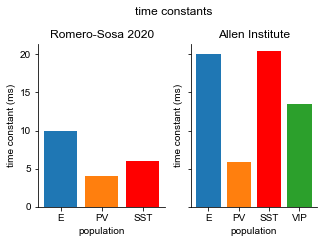

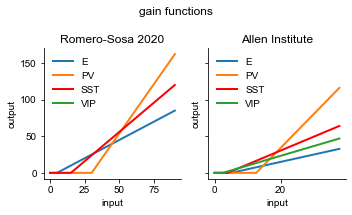

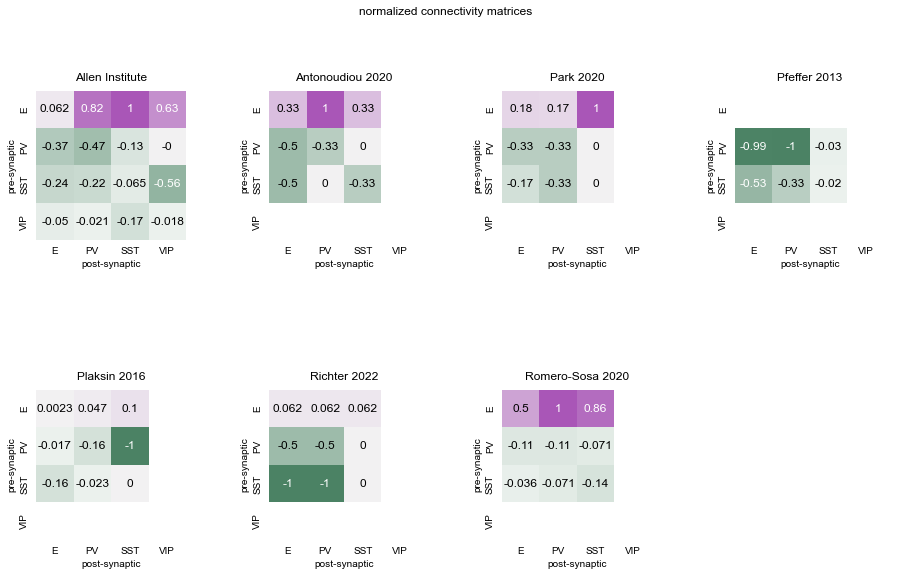

In [6]:
# Firing rate adaptation time constants 
figs['litreview tau'], axes = plt.subplots(
    1, len(tau_dict), figsize=(2.5 * len(tau_dict), 3), sharey=True)
figs['litreview tau'].suptitle('time constants', y=1.05)
for ax, (key, t) in zip(axes, tau_dict.items()):
    NetworkModel(tau=t).plot_time_constants(ax=ax)
    ax.set_title(key)

# Gain function parameters
figs['litreview fgains'], axes = plt.subplots(
    1, len(fparams_dict), figsize=(2.5 * len(fparams_dict), 3), sharey=True)
figs['litreview fgains'].suptitle('gain functions')
for ax, (key, fp) in zip(axes, fparams_dict.items()):
    NetworkModel(fparams=fp).plot_fgain(ax=ax)
    ax.set_title(key)

# Connectivity matrices
figs['litreview W'] = NetworkModel.plot_connectivity_matrix(W_dict, norm=True)

## 3-population (E, SST, PV) model

### Initialize model

 2025/07/31 18:44:21: initialized NetworkModel(E, PV, SST, VIP)
 2025/07/31 18:44:21: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 73.55it/s]


 2025/07/31 18:44:21: no activity detected in ['E', 'PV'] populations
 2025/07/31 18:44:21: no activity detected in ['E', 'PV'] populations


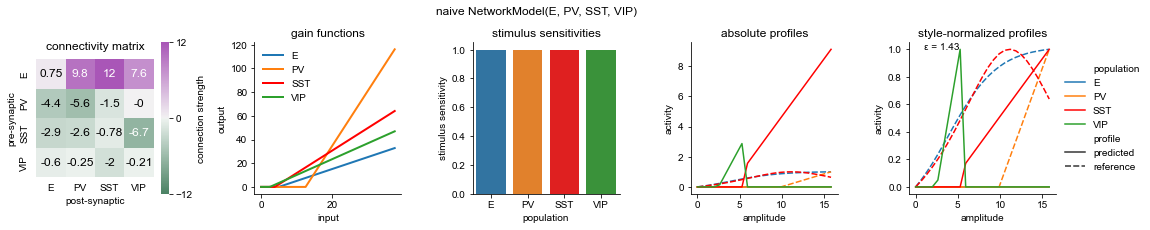

In [39]:
# Initialize model from defined source
source_key = 'Allen Institute'
model = NetworkModel(
    W=W_dict[source_key].copy(),
    tau=tau_dict[source_key].copy(), 
    fparams=fparams_dict[source_key].copy(),
)

# # Remove VIP population from the model
# model.remove_population('VIP')

# Extract rescaled connectivity matrix
Wref_rescaled = model.W.copy()

# Plot initial model parameters and simulated sweep results, compared to reference profiles
figs['initial model'] = model.plot_predictions(
    ref_profiles, norm_params=False, norm_res=[None, 'style'], title=f'naive {model}', height=3)

### Optimize model parameters for different sets of constraints

 2025/07/31 18:44:38: running 5 model optimization runs
 2025/07/31 18:44:38: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_wboundsed1f63fb4e07c38c9ee8b1bb2cc90d97_srelbounds0.0-5.0_diffev_norm_xdisp0.001_xwdev0.9_run0.h5
 2025/07/31 18:44:38: found optimal entry (cost = 2.52e-01)
 2025/07/31 18:44:38: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_wboundsed1f63fb4e07c38c9ee8b1bb2cc90d97_srelbounds0.0-5.0_diffev_norm_xdisp0.001_xwdev0.9_run1.h5
 2025/07/31 18:44:38: found optimal entry (cost = 2.31e-01)
 2025/07/31 18:44:38: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb6

100%|██████████| 25/25 [00:00<00:00, 45.45it/s]


 2025/07/31 18:44:41: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 41.39it/s]


 2025/07/31 18:44:43: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 47.71it/s]


 2025/07/31 18:44:45: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 46.01it/s]


 2025/07/31 18:44:46: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 42.58it/s]


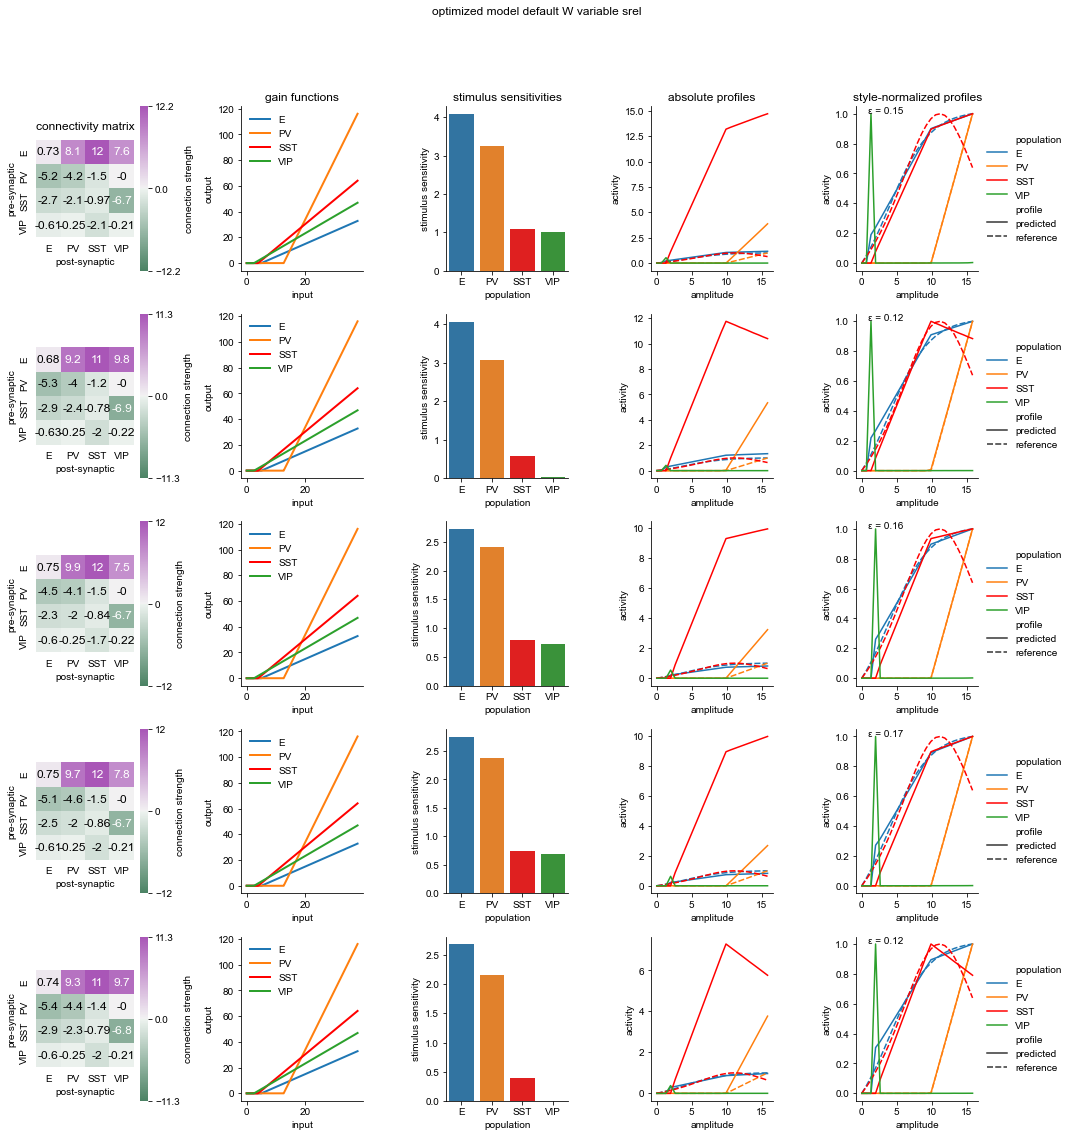

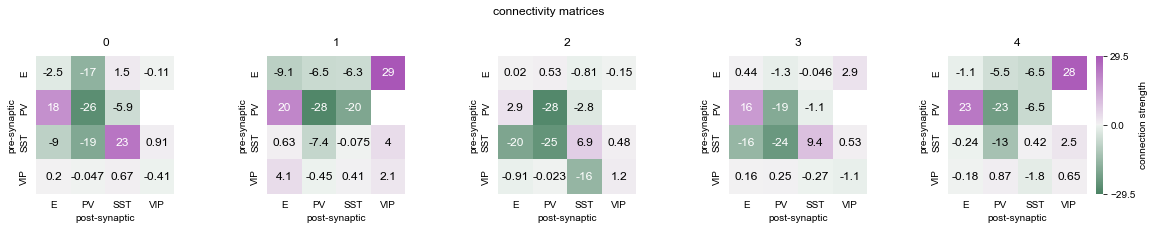

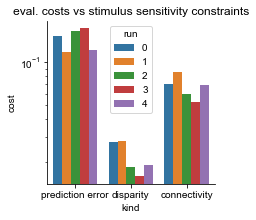

In [40]:
# Construct optimizer object
optimizer = ModelOptimizer(
    # Wdev_cost_factor=1.6
)

# Define model evaluation/optimization parameters
# Wbounds = None  # connectivity matrix exploration bounds
# Wbounds = model.get_coupling_bounds(wmax=WMAX)  # connectivity matrix exploration bounds
Wbounds = model.get_coupling_bounds(relwmax=RELWMAX)  # connectivity matrix exploration bounds

srel_bounds = (0, SRELMAX)  # stimulus sensitivity exploration bounds
srel_dists = {
    # 'uniform': True,
    'variable': False,
}

# For both uniform and variable stimulus sensitivity
costs_vs_srel = {}
for srel_key, uniform_srel in srel_dists.items():

    # Optimize model parameters to minimize divergence with reference profiles
    optres = optimizer.optimize(
        model, 
        ref_profiles,
        logdir=logdir, 
        mpi=True,
        Wbounds=Wbounds,
        srel_bounds=srel_bounds,
        uniform_srel=uniform_srel,
        nruns=5
    )

    # Plot optimized model parameters and simulated sweep results, compared to reference profiles
    title = f'optimized model default W {srel_key} srel'
    figs[title], costs = model.plot_predictions(
        ref_profiles, optres, norm_params=False, norm_res=[None, 'style'], title=title, 
        avg_across_runs=False, return_costs=True, height=3, Wref=Wref_rescaled)
    
    # Store prediction error
    costs_vs_srel[srel_key] = costs
    
    # Compute and plot relative change in connectivity matrices
    Werr = pd.concat(
        {k: model.get_relative_change(model.parse_optimum_vector(v)['W'], Wref_rescaled) for k, v in optres.iterrows()},
        axis=0, names=['run'])
    fig = model.plot_connectivity_matrix(Werr * 100, clabel='err (%)', colwrap=5, height=4)
    fig.subplots_adjust(bottom=0.4)

# Plot error statistics vs constraint options
costs_vs_srel = pd.concat(costs_vs_srel, names=['sensitivity'])
figs['opt costs'], ax = plt.subplots(figsize=(3, 3))
sns.despine(ax=ax)
ax.set_title('eval. costs vs stimulus sensitivity constraints')
ax = sns.barplot(
    data=costs_vs_srel.stack().rename('cost').reset_index(),
    x='kind',
    hue='run',
    # x='sensitivity',
    y='cost',
    errorbar='se',
)
ax.set_yscale('log')

 2025/07/31 18:32:53: initialized NetworkModel(E, PV, SST, VIP)
 2025/07/31 18:32:54: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 40.83it/s]


 2025/07/31 18:32:55: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 34.80it/s]


 2025/07/31 18:32:56: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 37.01it/s]


 2025/07/31 18:32:57: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 37.95it/s]


 2025/07/31 18:32:58: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 42.20it/s]


 2025/07/31 18:32:59: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 41.64it/s]


 2025/07/31 18:33:01: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 27.10it/s]


 2025/07/31 18:33:02: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 41.84it/s]


 2025/07/31 18:33:03: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 44.16it/s]


 2025/07/31 18:33:04: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 45.50it/s]


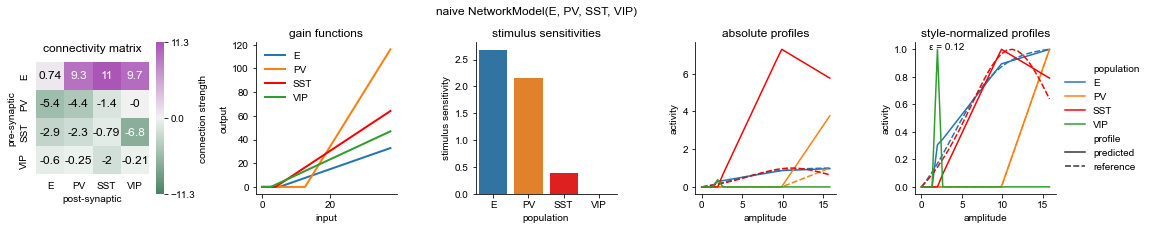

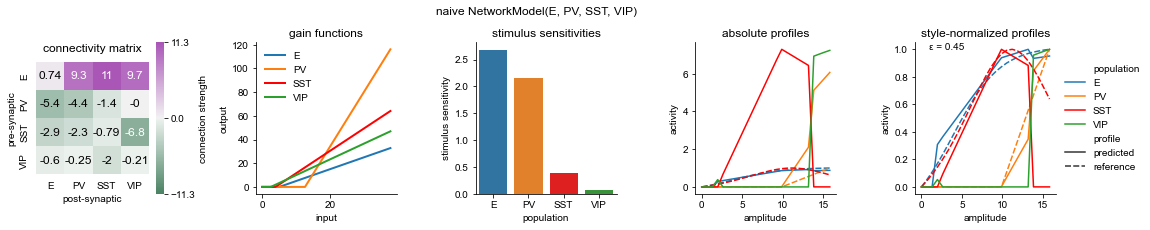

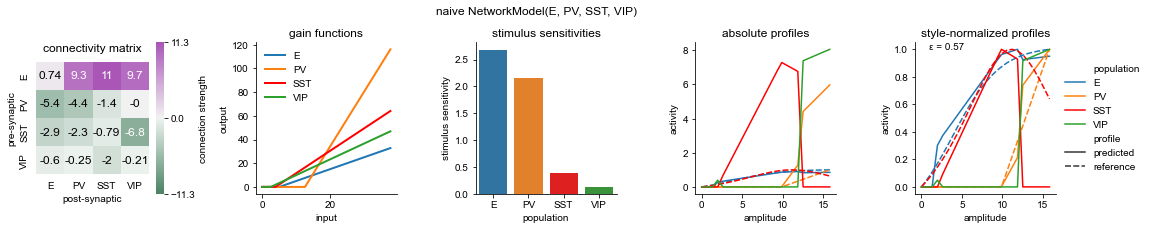

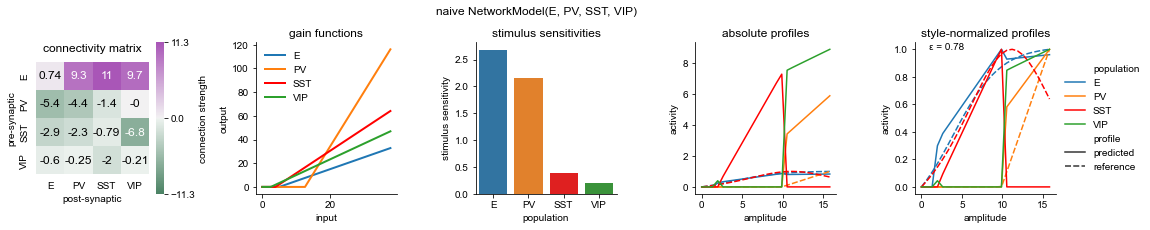

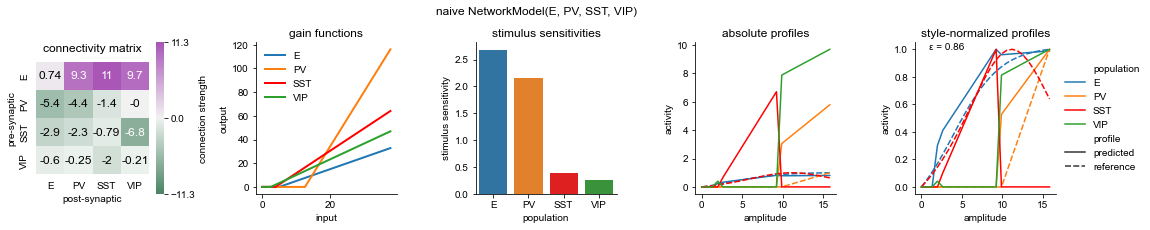

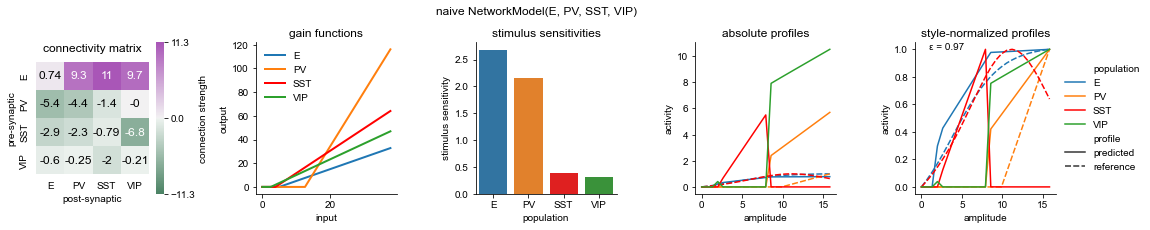

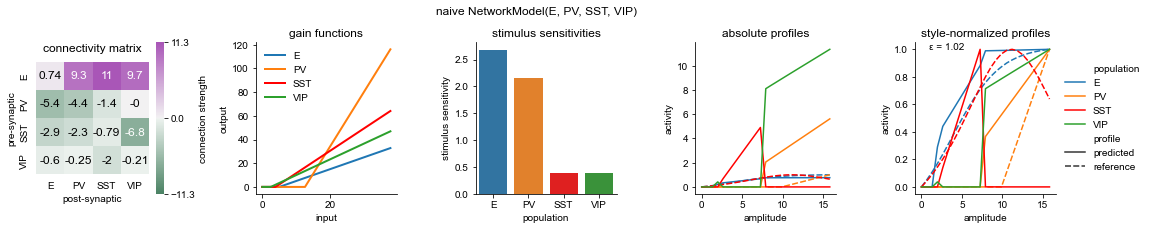

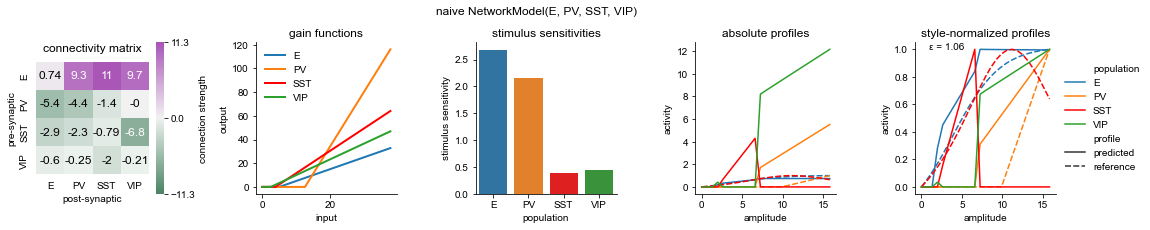

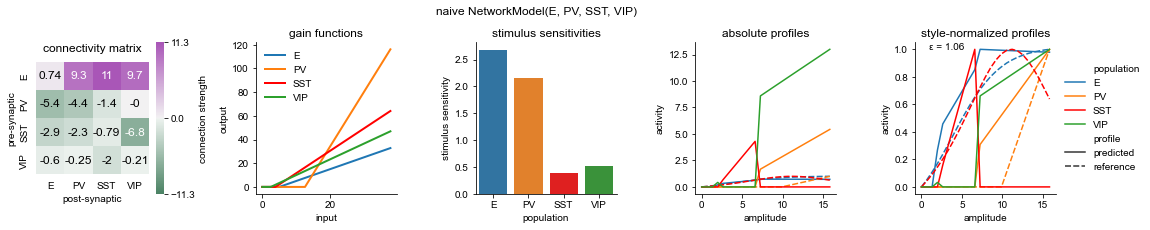

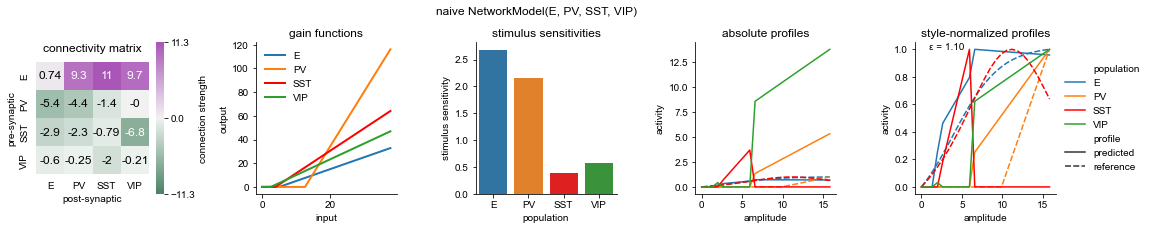

In [38]:
myopt = model.parse_optimum_vector(optres.loc[4])
myW, mysrel = myopt['W'], myopt['srel']

# Wref = model.W.copy()
# myW.loc['E', 'VIP'] = Wref.loc['E', 'VIP']

mymodel = model.copy()
mymodel.W = myW
mymodel.srel = mysrel
for vip_srel in np.linspace(0, 1.5, 10) * mysrel.loc['SST']:
    mymodel.srel.loc['VIP'] = vip_srel
    fig = mymodel.plot_predictions(
        ref_profiles, norm_params=False, norm_res=[None, 'style'], title=f'naive {model}', height=3)

### Simulate average optimal model

 2025/06/26 14:59:12: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 47.56it/s]


 2025/06/26 14:59:14: running stimulation sweep


100%|██████████| 3/3 [00:00<00:00, 49.15it/s]


 2025/06/26 14:59:14: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 44.10it/s]


 2025/06/26 14:59:15: running stimulation sweep


100%|██████████| 3/3 [00:00<00:00, 42.49it/s]


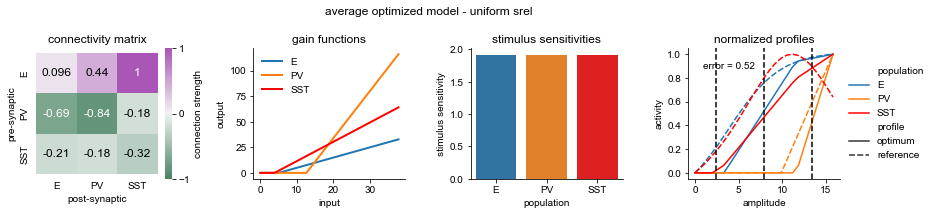

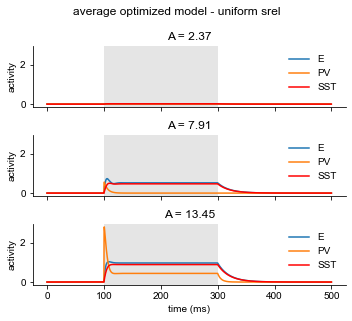

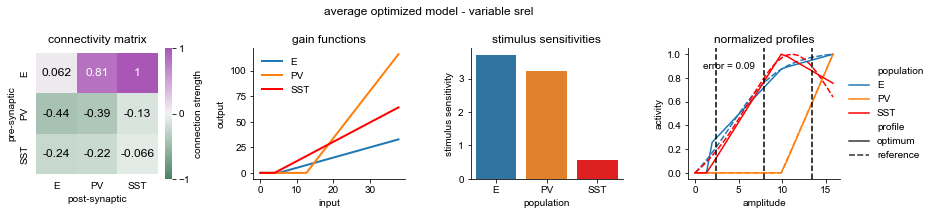

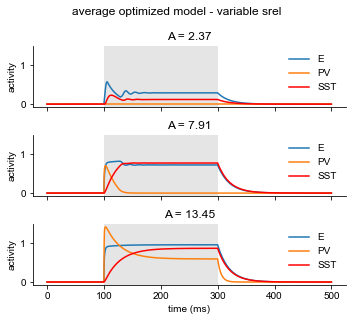

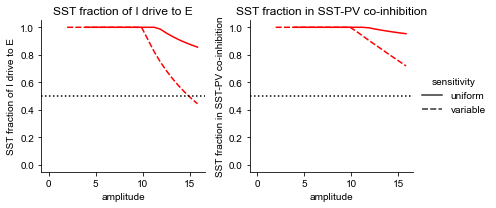

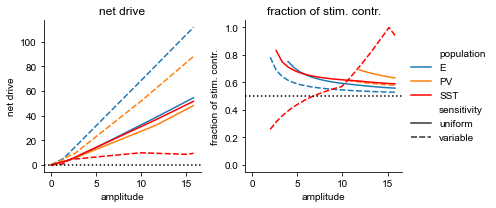

In [37]:
# Create dictionaries to store drive contribution metrics
net_drive_vs_srel = {}
rel_stim_drive_vs_srel = {}
rel_sst_E_drive_vs_srel = {}
rel_sst_I_drive_vs_srel = {}

# For each set of optimization constraints
for srel_key in srel_dists.keys():

    # Assign average optimum parameters to model
    model.W = Woptavg_vs_srel[srel_key]
    model.srel = srel_opt_avg_vs_srel[srel_key]

    # Run simulation sweep across input amplitudes
    sweep_data = model.run_stim_sweep(amps)
    sweep_rss = model.extract_response_magnitude(sweep_data)
    maxperpop = sweep_rss.max()

    # Compare results to reference profiles
    error = model.evaluate_stim_sweep(
        ref_profiles, sweep_data, norm=norm)['prediction error']
    sweep_comp = pd.concat({
        'optimum': sweep_rss,
        'reference': ref_profiles
    }, axis=0, names=['profile'])

    # Plot results
    figkey = f'optavg sweep comp {srel_key}'
    figs[figkey], axes = plt.subplots(1, 4, figsize=(12, 3))
    figs[figkey].suptitle(f'average optimized model - {srel_key} srel')
    model.plot_connectivity_matrix(W=model.W / model.W.abs().max().max(), ax=axes[0])
    model.plot_fgain(ax=axes[1])
    model.plot_stimulus_sensitivity(ax=axes[2])
    sweepax = axes[3]
    model.plot_sweep_results(sweep_comp, norm='style', ax=sweepax, style='profile')
    sweepax.set_title(f'{"normalized" if norm else "absolute"} profiles')
    sweepax.text(0.1, 0.9, f'error = {error:.2f}', transform=sweepax.transAxes, ha='left', va='top')
    sns.move_legend(sweepax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)

    # Plot detailed simulation results for a set of characteristic input amplitudes
    amp_range = amps.max() - amps.min()
    amps_sparse = np.linspace(amps.min() + 0.15 * amp_range, amps.max() - 0.15 * amp_range, 3)
    sweep_data_sparse = model.run_stim_sweep(amps_sparse)
    if norm:
        sweep_data_sparse[model.keys] /= maxperpop
    figkey = f'optavg timeseries {srel_key}'
    figs[figkey], axes = plt.subplots(
        amps_sparse.size, 1, figsize=(5, 1.5 * amps_sparse.size), 
        sharex=True, sharey=True)
    figs[figkey].suptitle(f'average optimized model - {srel_key} srel')
    for (A, sol), ax in zip(sweep_data_sparse.groupby('amplitude'), axes):
        sweepax.axvline(A, color='k', linestyle='--')
        model.plot_timeseries(sol.droplevel('amplitude'), title=f'A = {A:.2f}', axes=ax, plot_stimulus=False)

    # Compute steady-state stimulus drive over input amplitudes range 
    stim_drive = pd.DataFrame(
        data=np.outer(sweep_rss.index, model.srel),
        index=sweep_rss.index,
        columns=model.idx,
    )

    # Compute steady-state presynaptic drive onto eahh post-synaptic population by each pre-synaptic population
    presyn_drives = pd.concat({
        pop: model.W.loc[:, pop] * sweep_rss for pop in model.keys
    }, axis=0, names=['postsyn pop'])

    # Compute proportion of presynaptic inhibitory drive to excitatory neurons mediated by SST neurons 
    rel_SST_E_drive = (presyn_drives.loc['E', 'SST'] / presyn_drives.loc['E', ['PV', 'SST']].sum(axis=1))
    rel_SST_E_drive = rel_SST_E_drive.where(sweep_rss['E'] > 1e-2)

    # Compute relative strength of SST->PV drive w.r.t. PV-> SST drive 
    SST_PV_drive = presyn_drives.loc['PV', 'SST']
    PV_SS_drive = presyn_drives.loc['SST', 'PV']
    rel_SST_I_drive = SST_PV_drive / (SST_PV_drive + PV_SS_drive)
    rel_SST_I_drive = rel_SST_I_drive.where(sweep_rss['E'] > 1e-2)
    
    # Compute steady-state presynaptic drive over input amplitudes range 
    presyn_drive = model.compute_drive(sweep_rss).abs()

    # Compute total drive over input amplitudes range, and relative contribution 
    # of stimulus drive to evoked responses (when there is a response)
    total_drive = (presyn_drive + stim_drive)
    rel_stim_drive = (stim_drive / total_drive).where(sweep_rss > 1e-2)

    # Save drive metrics to dictionaries
    net_drive_vs_srel[srel_key] = total_drive
    rel_stim_drive_vs_srel[srel_key] = rel_stim_drive
    rel_sst_E_drive_vs_srel[srel_key] = rel_SST_E_drive
    rel_sst_I_drive_vs_srel[srel_key] = rel_SST_I_drive

# Concatenate drive contribution metrics across sets of constraints
rel_sst_drives_vs_srel = pd.DataFrame({
    'SST fraction of I drive to E': pd.concat(rel_sst_E_drive_vs_srel, axis=0, names=['sensitivity']),
    'SST fraction in SST-PV co-inhibition': pd.concat(rel_sst_I_drive_vs_srel, axis=0, names=['sensitivity']),
})
drives_vs_srel = pd.DataFrame({
    'net drive': pd.concat(net_drive_vs_srel, names=['sensitivity']).stack(),
    'fraction of stim. contr.': pd.concat(rel_stim_drive_vs_srel, names=['sensitivity']).stack(),
})

# Plot drives metrics vs. dose for each set of constraints
naxes = len(rel_sst_drives_vs_srel.columns)
figs['rel SST inhib contr. vs. dose per constraint'], axes = plt.subplots(1, naxes, figsize=(3.5 * naxes, 3))
for ax, k in zip(axes, rel_sst_drives_vs_srel.columns):
    sns.despine(ax=ax)
    sns.lineplot(
        ax=ax,
        data=rel_sst_drives_vs_srel.reset_index(),
        x='amplitude',
        y=k,
        c='r',
        style='sensitivity',
        legend=ax is axes[-1],
    )
    ax.set_xlim(-0.05 * amps.max(), 1.05 * amps.max())
    ax.set_ylim(-0.05, 1.05)
    ax.axhline(0.5, color='k', linestyle=':')
    ax.set_title(k)
sns.move_legend(axes[-1], bbox_to_anchor=(1, .5), loc='center left', frameon=False)
figs['rel SST inhib contr. vs. dose per constraint'].tight_layout()

naxes = len(drives_vs_srel.columns)
figs['drives vs. dose per constraint'], axes = plt.subplots(1, naxes, figsize=(3.5 * naxes, 3))
for ax, k in zip(axes, drives_vs_srel.columns):
    sns.despine(ax=ax)
    ax.set_title(k)
    sns.lineplot(
        ax=ax,
        data=drives_vs_srel.reset_index(),
        x='amplitude',
        y=k,
        hue='population',
        palette=model.palette,
        style='sensitivity',
    )
    yref = 0.5 if k.startswith('fraction') else 0
    ax.axhline(yref, color='k', linestyle=':')
    if k.startswith('fraction'):
        ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-0.05 * amps.max(), 1.05 * amps.max())
    if ax is axes[-1]:
        sns.move_legend(ax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)
    else:
        ax.get_legend().remove()
figs['drives vs. dose per constraint'].tight_layout()

### Simulate "disconnected" optimal models to obtain intrinsic response curves

 2025/06/26 15:01:47: initialized NetworkModel(E, PV, SST)
 2025/06/26 15:01:47: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 63.65it/s]


 2025/06/26 15:01:48: initialized NetworkModel(E, PV, SST)
 2025/06/26 15:01:48: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 61.03it/s]


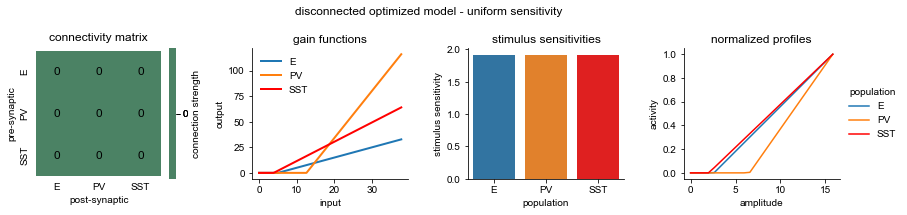

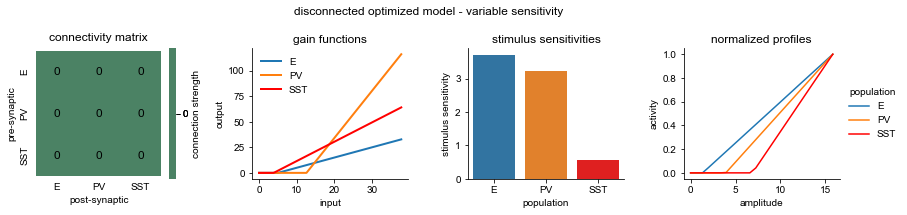

In [42]:
# For each set of optimization constraints
for srel_key in srel_dists.keys():
    
    # Create "disconnected" copy of model with null connectivity matrix
    disconnected_model = model.copy().disconnect()
    disconnected_model.srel = srel_opt_avg_vs_srel[srel_key]

    # Run simulation sweep across input amplitudes
    sweep_data = disconnected_model.run_stim_sweep(amps)
    sweep_rss = disconnected_model.extract_response_magnitude(sweep_data)

    # Plot results
    figkey = f'optavg disconnected model - {srel_key} srel'
    figs[figkey], axes = plt.subplots(1, 4, figsize=(12, 3))
    figs[figkey].suptitle(f'disconnected optimized model - {srel_key} sensitivity')
    disconnected_model.plot_connectivity_matrix(
        W=disconnected_model.W, ax=axes[0])
    disconnected_model.plot_fgain(ax=axes[1])
    disconnected_model.plot_stimulus_sensitivity(ax=axes[2])
    sweepax = axes[3]
    disconnected_model.plot_sweep_results(sweep_rss, norm=norm, ax=sweepax)
    sweepax.set_title(f'{"normalized" if norm else "absolute"} profiles')
    sns.move_legend(sweepax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)

### Disconnect specific populations to evaluate their causal impact on the system

 2025/06/26 15:01:56: initialized NetworkModel(E, PV, SST)
 2025/06/26 15:01:56: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 54.43it/s]

 2025/06/26 15:01:57: initialized NetworkModel(E, PV, SST)
 2025/06/26 15:01:57: running stimulation sweep



100%|██████████| 25/25 [00:00<00:00, 61.92it/s]

 2025/06/26 15:01:57: initialized NetworkModel(E, PV, SST)
 2025/06/26 15:01:57: running stimulation sweep



100%|██████████| 25/25 [00:00<00:00, 70.66it/s]

 2025/06/26 15:01:58: initialized NetworkModel(E, PV, SST)
 2025/06/26 15:01:58: running stimulation sweep



100%|██████████| 25/25 [00:00<00:00, 39.02it/s]

 2025/06/26 15:01:59: initialized NetworkModel(E, PV, SST)
 2025/06/26 15:01:59: running stimulation sweep



100%|██████████| 25/25 [00:00<00:00, 38.20it/s]


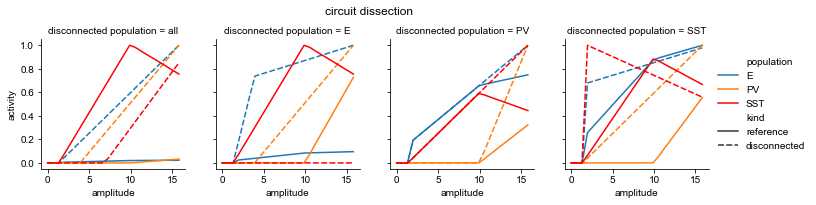

In [43]:
# Set up reference model parameters
srel_key = 'variable'
ref_model = model.copy()
ref_model.W = Woptavg_vs_srel[srel_key]
ref_model.srel = srel_opt_avg_vs_srel[srel_key]

# Run simulation sweep across input amplitudes
sweep_data = ref_model.run_stim_sweep(amps)
ref_rss = ref_model.extract_response_magnitude(sweep_data)

# Create list of dissection keys
disconnected_keys = ['all'] + list(model.keys)

# Create dictionary to store rss results per dissection
all_rss = {}

# For each population
for key in disconnected_keys:
    # Create copy of model with disconnected population(s)
    disconnected_model = ref_model.copy().disconnect(presyn_key=key)

    # Run simulation sweep across input amplitudes
    sweep_data = disconnected_model.run_stim_sweep(amps)
    sweep_rss = disconnected_model.extract_response_magnitude(sweep_data)

    # Store sweep results for both fully connected model and disconnected model
    all_rss[key] = pd.concat({
        'reference': ref_rss,
        'disconnected': sweep_rss,
    }, axis=0, names=['kind'])

# Format all_rss as DataFrame
all_rss = pd.concat(all_rss, axis=0, names=['disconnected population'])

# Plot results
figs[f'optavg model dissection'] = disconnected_model.plot_sweep_results(
    all_rss, 
    norm='ax', #'style', 
    col='disconnected population',
    style='kind',
    height=2.5,
    title='circuit dissection',
)

## Evaluate impact of changes in key connections on the network dynamics

 2024/10/06 23:20:34: initialized NetworkModel(E, PV, SST)
 2024/10/06 23:20:34: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 53.20it/s]

 2024/10/06 23:20:35: initialized NetworkModel(E, PV, SST)
 2024/10/06 23:20:35: running stimulation sweep



100%|██████████| 25/25 [00:00<00:00, 46.55it/s]


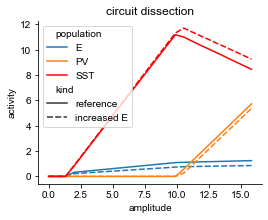

In [16]:
# Set up reference model parameters
srel_key = 'variable'
ref_model = model.copy()
ref_model.W = Woptavg_vs_srel[srel_key]
ref_model.srel = srel_opt_avg_vs_srel[srel_key]

# Run simulation sweep across input amplitudes
sweep_data = ref_model.run_stim_sweep(amps)
ref_rss = ref_model.extract_response_magnitude(sweep_data)

# Evaluate impct of 10% increase in E drive on all populations
perturb = 0.5

test_model = ref_model.copy()
test_model.W.loc['E'] += perturb * test_model.W.loc['E']

# Run simulation sweep across input amplitudes
sweep_data = test_model.run_stim_sweep(amps)
sweep_rss = test_model.extract_response_magnitude(sweep_data)

# Store sweep results for both fully connected model and disconnected model
all_rss = pd.concat({
    'reference': ref_rss,
    'increased E': sweep_rss,
}, axis=0, names=['kind'])

# Plot results
fig = disconnected_model.plot_sweep_results(
    all_rss, 
    norm=False,
    # norm='ax', #'style', 
    style='kind',
    height=2.5,
    title='circuit dissection',
)

## State-dependency analysis

### Orthogonal explorations (varying 1 population baseline at a time)

 2024/09/09 23:05:43: computing reference profiles
 2024/09/09 23:05:43: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 46.79it/s]


 2024/09/09 23:05:43: finding baseline E drive required to reach E = 1.24 steady state activity
 2024/09/09 23:05:43: finding baseline PV drive required to reach PV = 5.72 steady state activity
 2024/09/09 23:05:43: finding baseline SST drive required to reach SST = 11.17 steady state activity
 2024/09/09 23:05:43: E population, low baseline drive
 2024/09/09 23:05:43: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 47.17it/s]


 2024/09/09 23:05:44: running stimulation sweep


100%|██████████| 3/3 [00:00<00:00, 42.32it/s]


 2024/09/09 23:05:44: E population, mid baseline drive
 2024/09/09 23:05:44: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 26.97it/s]


 2024/09/09 23:05:45: running stimulation sweep


100%|██████████| 3/3 [00:00<00:00, 25.20it/s]


 2024/09/09 23:05:46: E population, high baseline drive
 2024/09/09 23:05:46: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 27.10it/s]

 2024/09/09 23:05:47: running stimulation sweep



100%|██████████| 3/3 [00:00<00:00, 27.66it/s]


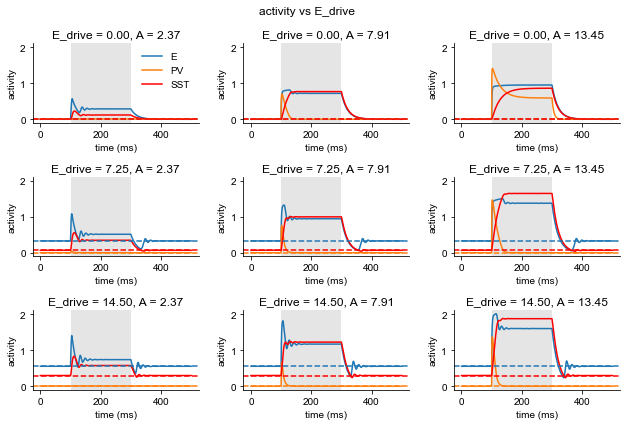

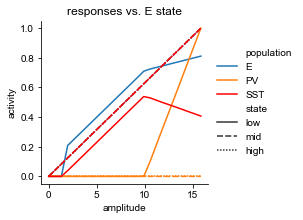

In [25]:
# %%skip $skip_state_dep

# Assign average optimum parameters to model
srel_key = 'variable'
model.W = Woptavg_vs_srel[srel_key]
model.srel = srel_opt_avg_vs_srel[srel_key]
model.tau = tau_ref
# model.tau = pd.Series(index=model.idx, data=50 * np.ones(model.idx.size))

# Initialize baseline drives to zero
model.b = pd.Series(index=pd.Index(POPULATIONS, name='population'), data=0)

# Run simulation sweep across input amplitudes and extract max ss-activity per population
logger.info('computing reference profiles')
sweep_data = model.run_stim_sweep(amps)  # tau_stim=30)
sweep_rss = model.extract_response_magnitude(sweep_data)
maxperpop = sweep_rss.max()

# Find baseline excitatory drive yielding max evoked excitatory activity 
pop = 'E'
bmax = model.find_baseline_drives(maxperpop).loc[pop]

# Define relative baseline drives w.r.t. maximum excitatory drive
rel_bdrives = {'low': 0., 'mid': .25, 'high': .5}

# Initialize dictiionary of sweep results per baseline drive
sweep_rss_vs_state = {}

# Initialize figure for detailed simulation results
fig, axes = plt.subplots(
    len(rel_bdrives), amps_sparse.size, 
    figsize=(3 * amps_sparse.size, 2 * len(rel_bdrives))
)
fig.suptitle(f'activity vs {pop}_drive')

# For each baseline drive
for (k, relb), axrow in zip(rel_bdrives.items(), axes):
    logger.info(f'{pop} population, {k} baseline drive')
    # Set population baseline drive
    model.b.loc[pop] = relb * bmax

    # Compute expected baseline activity in each population for that drive
    baseline_ss = model.compute_steady_state()

    # Run simulation sweep across input amplitudes
    sweep_data = model.run_stim_sweep(amps)

    # Extract response magnitudes from simulation sweep
    sweep_rss_vs_state[k] = model.extract_response_magnitude(sweep_data, metric='ss')

    # Plot detailed simulation results for a set of characteristic input amplitudes
    amp_range = amps.max() - amps.min()
    amps_sparse = np.linspace(amps.min() + 0.15 * amp_range, amps.max() - 0.15 * amp_range, 3)
    sweep_data_sparse = model.run_stim_sweep(amps_sparse)
    # del sweep_data_sparse['x']
    if norm:
        sweep_data_sparse[POPULATIONS] /= maxperpop
        baseline_ss /= maxperpop

    prefix = f'{pop}_drive = {model.b.loc[pop]:.2f}'
    for (A, sol), ax in zip(sweep_data_sparse.groupby('amplitude'), axrow):
        model.plot_timeseries(
            sol.droplevel('amplitude'), title=f'{prefix}, A = {A:.2f}', axes=ax, plot_stimulus=False)
        for pkey, pval in baseline_ss.items():
            ax.axhline(pval, color=model.palette[pkey], linestyle='--')

harmonize_axes_limits(axes.ravel(), 'y')
for ax in axes.ravel()[1:]:
    ax.legend().remove()

# Reset baseline drive to zero
model.b.loc[pop] = 0.

# Assemble sweep vs. state results into DataFrame
sweep_rss_vs_state = pd.concat(sweep_rss_vs_state, names=['state'])

# Plot sweep vs. state results
figs['optavg sweep vs baseline'], sweepax = plt.subplots(figsize=(3, 3))
model.plot_sweep_results(
    sweep_rss_vs_state, 
    norm='ax',
    ax=sweepax,
    style='state', style_order=rel_bdrives.keys()
)
sweepax.set_title(f'responses vs. {pop} state')
sns.move_legend(sweepax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)

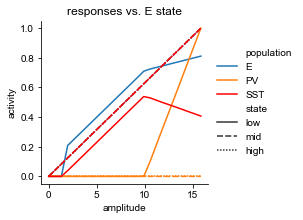

In [28]:
# Plot sweep vs. state results
figs['optavg sweep vs baseline'], sweepax = plt.subplots(figsize=(3, 3))
model.plot_sweep_results(
    sweep_rss_vs_state, 
    norm='ax',
    ax=sweepax,
    style='state', style_order=rel_bdrives.keys()
)
sweepax.set_title(f'responses vs. {pop} state')
sns.move_legend(sweepax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)

### Combined explorations (varying all population baselines and binning final results)

In [12]:
%%skip $skip_state_dep

# Set number of random combinations to generate
ncombinations = 1000

# Determine bounds for baselines drives for each population
beq = model.find_baseline_drives(maxperpop)

# Generate random combinations of baseline drives for each population
baselines = pd.DataFrame(
    data=np.random.uniform(0, 1, size=(ncombinations, len(POPULATIONS))),
    columns=beq.index
) * beq
baselines.index.name = 'combination'

# Simulate model for each combination of baseline drives to get response profiles
states = {}
responses = {}
# Catch all warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for icomb, baseline in tqdm(baselines.iterrows()):
        model.b = baseline
        states[icomb] = model.compute_steady_state()
        sweep_data = model.run_stim_sweep(amps, verbose=False)
        responses[icomb] = model.extract_response_magnitude(sweep_data)
responses = pd.concat(responses, names=['combination'])
states = pd.concat(states, names=['combination'], axis=1).T

# Bin states by quantile intervals
nbins = 2
binned_states = pd.concat(
    {k: bin_by_quantile_intervals(states, k, nbins=nbins, add_aggregate=False)
     for k in states.columns},
    axis=1,
    names=['population']
)
# binned_states = binned_states.map(mapper)
fig, axes = plt.subplots(1, len(POPULATIONS), figsize=(3 * len(POPULATIONS), 3))

# Normalize responses to [0, 1] range for each population
avgmaxperpop = (
    responses.groupby('combination')
    .agg(lambda x: x.abs().max())
    .mean()
)
normresponses = responses / avgmaxperpop

# For each population, plot response profile as a function of state category
for k, ax in zip(POPULATIONS, axes):
    sns.despine(ax=ax)
    ax.set_title(f'{k} state-dep')
    tmpdf = pd.concat([
        free_expand(binned_states[k].rename('state'), normresponses),
        normresponses[k].rename('response'),
    ], axis=1)
    sns.lineplot(
        data=tmpdf.reset_index(),
        x='amplitude',
        y='response',
        # units='combination', estimator=None, alpha=0.5,
        estimator='mean',
        errorbar='se',
        hue='state',
        hue_order=['low', 'high'],
        palette={'low': 'dimgray', 'high': 'goldenrod'},
        ax=ax,
        legend=ax is axes[-1]
    )
sns.move_legend(axes[-1], bbox_to_anchor=(1, .5), loc='center left', frameon=False)
fig.tight_layout()

### Save figures

In [203]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix='network_model')

 2024/10/03 11:49:16: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2024.10.03/figs_network_model.pdf:


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


### Notify upon completion

In [16]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'circuit model analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/09/06 14:00:30: circuit model analysis notebook completed in 0:03:17.815912 s
